In [75]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from torch.utils.data import Dataset

In [76]:
# Step 1: Load and Preprocess Data
fake = pd.read_csv("C:/Users/OMEN/Desktop/FakeNews_Best_Model/archive/Fake.csv")
true = pd.read_csv("C:/Users/OMEN/Desktop/FakeNews_Best_Model/archive/True.csv")

In [77]:
# Drop irrelevant columns
fake.drop(['subject', 'date'], axis=1, inplace=True)
true.drop(['subject', 'date'], axis=1, inplace=True)
# Assign labels
fake['label'] = 1
true['label'] = 0

In [78]:
# Combine and shuffle
data = pd.concat([fake, true], axis=0).sample(frac=1).reset_index(drop=True)
data.fillna(' ', inplace=True)

In [79]:
# Extract raw text and labels
texts = data['text'].tolist()
labels = data['label'].tolist()

In [80]:
# 🔻 Optional: use small subset for fast training
texts = texts[:2000]
labels = labels[:2000]

In [81]:
# Step 2: Train/Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [82]:
# Step 2: Load small BERT model
model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [83]:
# # Step 3: Tokenize with BERT
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
# val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)


In [84]:
# Step 3: Tokenize (shorter sequence for speed)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {
            "labels": torch.tensor(self.labels[idx])
        }
    def __len__(self):
        return len(self.labels)

train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)

In [85]:
# # Step 4: Prepare Dataset Class
# class FakeNewsDataset(Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels
        
#     def __getitem__(self, idx):
#         return {
#             key: torch.tensor(val[idx]) for key, val in self.encodings.items()
#         } | {"labels": torch.tensor(self.labels[idx])}
    
#     def __len__(self):
#         return len(self.labels)

# train_dataset = FakeNewsDataset(train_encodings, train_labels)
# val_dataset = FakeNewsDataset(val_encodings, val_labels)

In [86]:
# Step 4: Training settings
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

c:\Users\OMEN\anaconda3\envs\BERT\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [87]:
# # Step 5: Load Model and Training Config
# model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=2,
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=10,
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
# )


In [88]:
# # Step 6: Train and Evaluate
# trainer.train()
# eval_results = trainer.evaluate()

# print("Evaluation Results:", eval_results)

In [89]:
# Step 5: Train and evaluate
trainer.train()
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Epoch,Training Loss,Validation Loss
1,0.342500,0.271747
2,0.190400,0.169258


Evaluation Results: {'eval_loss': 0.1692579984664917, 'eval_runtime': 0.1166, 'eval_samples_per_second': 3429.142, 'eval_steps_per_second': 214.321, 'epoch': 2.0}


In [90]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

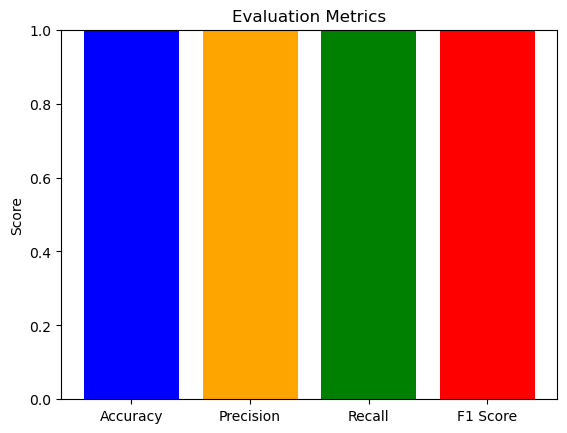

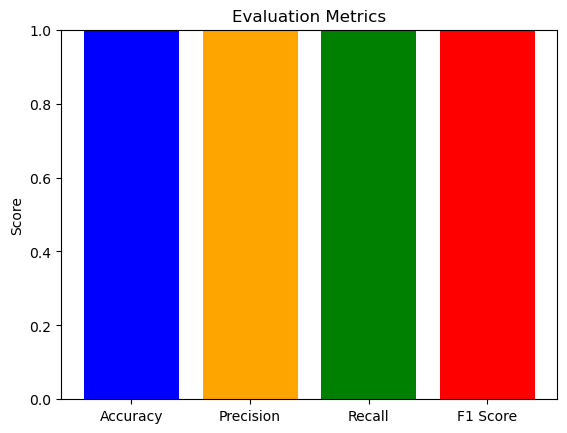

Metrics: {'Accuracy': 0.9975, 'Precision': 0.9954954954954955, 'Recall': 1.0, 'F1 Score': 0.9977426636568849}


In [91]:
# Get predictions from the trainer
predictions = trainer.predict(val_dataset)

# Compute and display metrics
metrics = compute_metrics(predictions)
print("Metrics:", metrics)
